In [12]:
import io_read
import preprocess
import numpy as np
from nn import NeuralNetwork
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [13]:
# load positive sequences
pos_seqs = io_read.read_text_file("../data/rap1-lieb-positives.txt")
print(f"loaded {len(pos_seqs)} positive sequences")

# load negative sequences
neg_seqs = io_read.read_fasta_file("../data/yeast-upstream-1k-negative.fa")
print(f"loaded {len(neg_seqs)} negative sequences")


loaded 137 positive sequences
loaded 3163 negative sequences


In [14]:
# combine positive and negative sequences before calling sample_seqs()
all_seqs = pos_seqs + neg_seqs  # merge both sets of sequences
all_labels = [1] * len(pos_seqs) + [0] * len(neg_seqs)  # 1 for positive, 0 for negative

# sample sequences using the updated function
sampled_seqs, sampled_labels = preprocess.sample_seqs(all_seqs, all_labels)

# should be balanced 
print(f"sampled {len(sampled_seqs)} sequences")


sampled 274 sequences


In [15]:
# one-hot encode the sampled sequences
X_encoded = preprocess.one_hot_encode_seqs(sampled_seqs)

# convert labels to a numpy array for compatibility with training
y_encoded = np.array(sampled_labels)

print(f"encoded sequences shape: {X_encoded.shape}")
print(f"labels shape: {y_encoded.shape}")


encoded sequences shape: (274, 17, 4)
labels shape: (274,)


In [16]:
# shuffle the dataset before splitting
indices = np.arange(len(X_encoded))
np.random.shuffle(indices)

X_encoded, y_encoded = X_encoded[indices], y_encoded[indices]

# defining 80/20 split index 
split_idx = int(0.8 * len(X_encoded))

# split into training and validation sets
X_train, X_val = X_encoded[:split_idx], X_encoded[split_idx:]
y_train, y_val = y_encoded[:split_idx], y_encoded[split_idx:]

print(f"training set shape: {X_train.shape}, labels: {y_train.shape}")
print(f"validation set shape: {X_val.shape}, labels: {y_val.shape}")


training set shape: (219, 17, 4), labels: (219,)
validation set shape: (55, 17, 4), labels: (55,)


In [17]:
# flatten the sequences from (N, 17, 4) to (N, 68)
X_train_flat = X_train.reshape(X_train.shape[0], -1).T
X_val_flat = X_val.reshape(X_val.shape[0], -1).T

print(f"flattened training set shape: {X_train_flat.shape}")
print(f"flattened validation set shape: {X_val_flat.shape}")


flattened training set shape: (68, 219)
flattened validation set shape: (68, 55)


In [18]:
# define the classifier architecture
classifier_arch = [
    {"input_dim": 68, "output_dim": 32, "activation": "relu"},  # hidden layer
    {"input_dim": 32, "output_dim": 1, "activation": "sigmoid"}  # output layer (binary classification)
]

# initialize the classifier
classifier = NeuralNetwork(
    nn_arch=classifier_arch, 
    lr=0.005, 
    seed=42,        
    batch_size=32,   
    epochs=2225, 
    loss_function="binary_cross_entropy"  # using BCE since it's a classification problem
)

print("classifier initialized")


classifier initialized


In [19]:
# reshape labels to ensure (1, N) instead of (N, 1)
y_train = y_train.reshape(1, -1)
y_val = y_val.reshape(1, -1)

print("training the classifier, this might take a moment")
# train the classifier
train_loss, val_loss = classifier.fit(X_train_flat, y_train, X_val_flat, y_val)

print("training done")


training the classifier, this might take a moment
training done


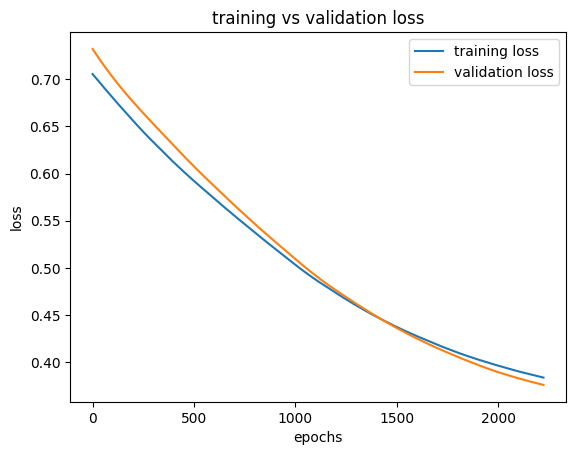

validation accuracy: 0.9636


In [21]:
# plot training and validation loss
plt.plot(train_loss, label="training loss")
plt.plot(val_loss, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("training vs validation loss")
plt.legend()
plt.show()

# get predictions from the classifier
y_val_pred = classifier.forward(X_val_flat)[0]  # raw output
y_val_pred = (y_val_pred > 0.5).astype(int)  # convert probabilities to 0 or 1

# compute accuracy
accuracy = accuracy_score(y_val.flatten(), y_val_pred.flatten())
print(f"validation accuracy: {accuracy:.4f}")

In [ ]:
"""
explanation of loss function and hyperparameters 

i originally set my lr =.01 and and epochs = 2225 from the digits notebook because that's worked well for it, but i got an accuracy of 56.36% 

i also saw that the training and validation loss graph had some pretty explosive spikes and thought that training might be unstable 

so i decreased the learning rate to .005 (epochs = 2225 still) and got an accuracy of 96.36% (i tried 3000 epochs at this lr, but it gave me
a lower acc of 92.73%

i also chose BCE over MSE because BCE handles classification better in the way loss behaves and gradients propagate
"""